# A simple 2D Flow Matching model

## Imports and init device

In [1]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt
import numpy as np



In [2]:
#torch.manual_seed(42)

## Dataset

Time shape: torch.Size([10, 100])
X shape: torch.Size([10, 100])


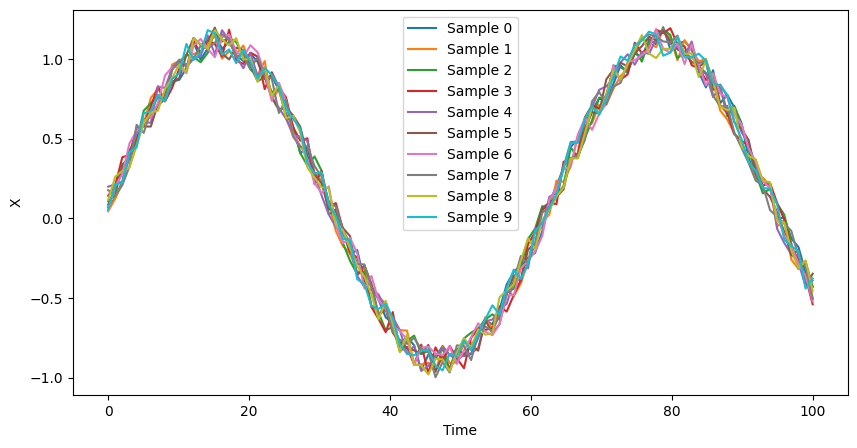

In [3]:
def gen_data(batch_size: int, seq_length: int = 100):
    t = torch.linspace(0, 100, seq_length).repeat(batch_size, 1)  # Shape: (n_samples, seq_length)
    x = torch.sin(t / 10) + 0.2 * torch.rand_like(t)  # Add independent noise per sample
    
    return t.float(), x.float()

# Example: Generate 10 samples of time series
t_samples, x_samples = gen_data(batch_size=10)

print("Time shape:", t_samples.shape)  
print("X shape:", x_samples.shape)  

plt.figure(figsize=(10, 5))
for i in range(t_samples.shape[0]):
    plt.plot(t_samples[i], x_samples[i], label=f"Sample {i}")


plt.xlabel("Time")
plt.ylabel("X")
plt.legend()
plt.show()

## Model

In [4]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class: Input is previous value(s) of x. Output is the vector field. 
class MLP(nn.Module):
    def __init__(self, input_dim: int = 1, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

## Train Velocity Flow Matching model

In [76]:
# training arguments
lr = 0.001
batch_size = 2
iterations = 10000
print_every = 100 
hidden_dim = 64

# velocity field model init
vf = MLP(input_dim=1, time_dim=1, hidden_dim=hidden_dim)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() 

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    _, x_values = gen_data(batch_size=1) # sample data

    # randomly select four consecutive points from x_values
    rand_idx = 0
    
    while rand_idx ==0 or rand_idx + 4 > x_values.shape[1]:
        rand_idx = torch.randint(0, x_values.shape[1]-4, (1,))

    x_0 = x_values[:, rand_idx:rand_idx+4]
    x_1 = x_values[:, rand_idx+4]


    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0])

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow(vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 

    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()

| iter    100 |  0.88 ms/step | loss    0.044 
| iter    200 |  0.61 ms/step | loss    0.056 
| iter    300 |  0.50 ms/step | loss    0.102 
| iter    400 |  0.49 ms/step | loss    0.029 
| iter    500 |  0.53 ms/step | loss    0.039 
| iter    600 |  0.51 ms/step | loss    0.045 
| iter    700 |  0.49 ms/step | loss    0.100 
| iter    800 |  0.49 ms/step | loss    0.048 
| iter    900 |  0.49 ms/step | loss    0.017 
| iter   1000 |  0.53 ms/step | loss    0.042 
| iter   1100 |  0.48 ms/step | loss    0.006 
| iter   1200 |  0.48 ms/step | loss    0.007 
| iter   1300 |  0.48 ms/step | loss    0.020 
| iter   1400 |  0.49 ms/step | loss    0.071 
| iter   1500 |  0.51 ms/step | loss    0.115 
| iter   1600 |  0.51 ms/step | loss    0.039 
| iter   1700 |  0.49 ms/step | loss    0.035 
| iter   1800 |  0.49 ms/step | loss    0.098 
| iter   1900 |  0.48 ms/step | loss    0.036 
| iter   2000 |  0.56 ms/step | loss    0.058 
| iter   2100 |  0.48 ms/step | loss    0.079 
| iter   2200

#### Sample from trained model

In [77]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [78]:
# step size for ode solver
step_size = 0.1

batch_size = 1  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,100)  # sample times


x_init = torch.randn((batch_size, 1), dtype=torch.float32)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

sol = sol.detach().numpy()
T = T.detach().numpy()

### Visualize the path

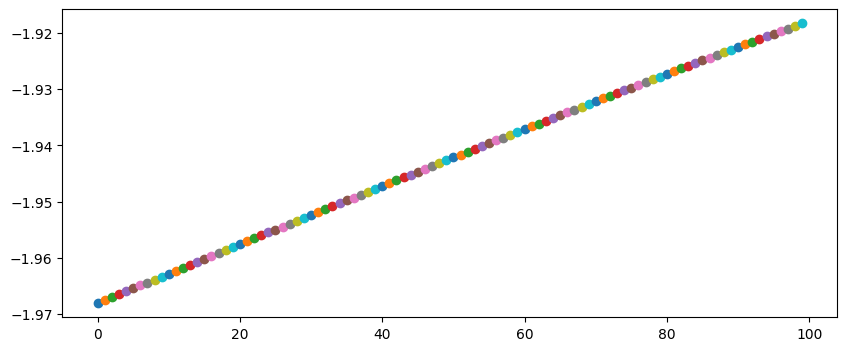

In [79]:

fig, axs = plt.subplots(1, 1,figsize=(10,4))

# change sol from tensor tor numpy



for i in range(len(sol)):
    axs.plot(i, sol[i][0], 'o', label=f"Sample {i}")

#axs.set_xlim(sol[0][0], sol[-1][0])

## Compute and Visualize Model Log-likelihood

In [10]:
from torch.distributions import Independent, Normal

In [11]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)

In [12]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p

log_p_acc /= num_acc

# compute with exact divergence
_, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

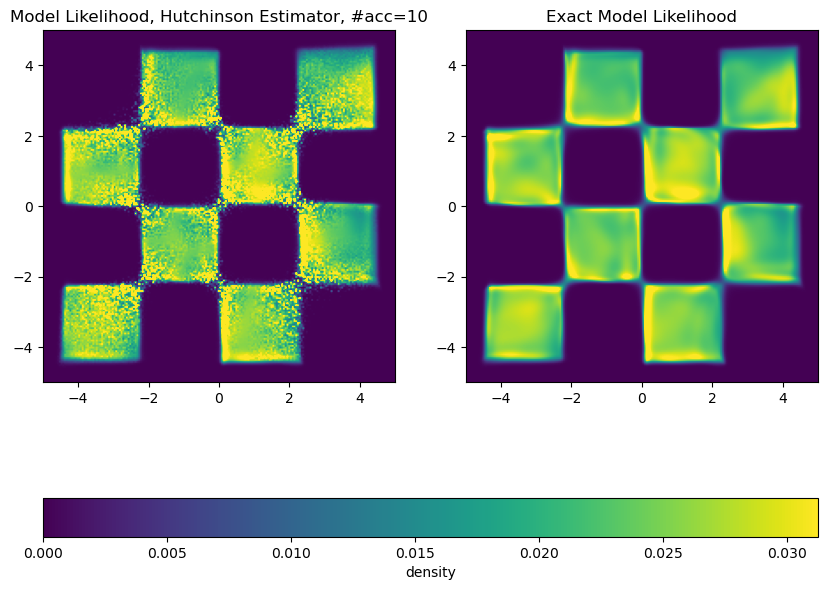

In [13]:
likelihood = torch.exp(log_p_acc).cpu().reshape(grid_size, grid_size).detach().numpy()
exact_likelihood = torch.exp(exact_log_p).cpu().reshape(grid_size, grid_size).detach().numpy()

fig, axs = plt.subplots(1, 2,figsize=(10,10))

cmin = 0.0
cmax = 1/32 # 1/32 is the gt likelihood value

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

axs[0].imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[0].set_title('Model Likelihood, Hutchinson Estimator, #acc=%d' % num_acc)

axs[1].imshow(exact_likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
axs[1].set_title('Exact Model Likelihood')

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs, orientation='horizontal', label='density')
plt.show()